# Big Data - TP #4

Integrantes: Ronny M. Condor, Diego Fasan y María Camila Riancho

El objetivo de este TP es hacer clasificación y regularización aplicada a la EPH.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm     

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


## Parte I: Análisis de la base de hogares y cálculo de pobreza

1. Importamos la base de datos del primer trimestre del 2023. Conservamos las observaciones de CABA y Gran Buenos Aires.

In [4]:
#1) Abrimos el archivo y vemos las primeras cinco filas
eph_hogar = pd.read_excel("../datasets/usu_hogar_T123.xlsx")
eph_hogar.head(5)

# Nos quedamos con las observaciones que pertenecen CABA o Gran Buenos Aires.

#El siguiente código toma el índice de aquellas observaciones para las que el aglomerado no es ni CABA (32) ni Gran Buenos Aires (33), y elimina las filas que cumplen esa condición. 

eph_hogar = eph_hogar.drop(eph_hogar[(eph_hogar["AGLOMERADO"] != 32) & (eph_hogar["AGLOMERADO"] != 33)].index)

#Para comprobar que funcionó, presentamos los valores que toma la variable "AGLOMERADO":

print(eph_hogar["AGLOMERADO"].unique() ) #Vemos que ahora "Aglomerado" solo toma los valores 32 y 33

[33 32]


In [5]:
#Resumen de la base de datos
eph_hogar.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16815 entries, 0 to 16814
Data columns (total 88 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CODUSU      16815 non-null  object 
 1   ANO4        16815 non-null  int64  
 2   TRIMESTRE   16815 non-null  int64  
 3   NRO_HOGAR   16815 non-null  int64  
 4   REALIZADA   16815 non-null  int64  
 5   REGION      16815 non-null  int64  
 6   MAS_500     16815 non-null  object 
 7   AGLOMERADO  16815 non-null  int64  
 8   PONDERA     16815 non-null  int64  
 9   IV1         16815 non-null  int64  
 10  IV1_ESP     42 non-null     object 
 11  IV2         16815 non-null  int64  
 12  IV3         16815 non-null  int64  
 13  IV3_ESP     22 non-null     object 
 14  IV4         16815 non-null  int64  
 15  IV5         16815 non-null  int64  
 16  IV6         16815 non-null  int64  
 17  IV7         16815 non-null  int64  
 18  IV7_ESP     15 non-null     object 
 19  IV8         16815 non-nul

In [6]:
#3) Abrimos la base individual
eph_indiv = pd.read_excel("../datasets/usu_individual_T123.xlsx")
eph_indiv.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH
0,TQRMNORVWHLMKOCDEOHCH00720228,2023,1,1,5,0,44,N,91,112,...,10.0,9,79700.0,6,6.0,5,NaN,7.0,5,133
1,TQRMNOPSTHKMKPCDEOHCH00781447,2023,1,1,1,1,44,N,91,190,...,6.0,5,180000.0,9,10.0,9,NaN,10.0,9,200
2,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,1,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
3,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,2,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
4,TQRMNOQYTHMNKSCDEOHCH00803178,2023,1,1,1,1,44,N,91,120,...,12.0,12,0.0,12,12.0,12,NaN,12.0,12,0


In [7]:
#Unimos las bases de tal manera de quedarnos con las observaciones a nivel individuo, sumando las variables a nivel hogar presentes en la encuesta de hogar:

eph=eph_indiv.merge(eph_hogar, on=['CODUSU','NRO_HOGAR'], how='left')

In [8]:
eph.head(5)

,CODUSU,ANO4_x,TRIMESTRE_x,NRO_HOGAR,COMPONENTE,H15,REGION_x,MAS_500_x,AGLOMERADO_x,PONDERA_x,...,GDECCFR_y,PDECCFR_y,ADECCFR_y,PONDIH_y,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNORVWHLMKOCDEOHCH00720228,2023,1,1,5,0,44,N,91,112,...,NaN,7.0,5,133,2,0,96,0,0,0
1,TQRMNOPSTHKMKPCDEOHCH00781447,2023,1,1,1,1,44,N,91,190,...,NaN,10.0,9,200,1,0,98,0,0,0
2,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,1,1,44,N,91,134,...,NaN,9.0,8,140,1,2,98,0,0,0
3,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,2,1,44,N,91,134,...,NaN,9.0,8,140,1,2,98,0,0,0
4,TQRMNOQYTHMNKSCDEOHCH00803178,2023,1,1,1,1,44,N,91,120,...,NaN,12.0,12,0,2,0,3,4,0,0


In [9]:
#Resumen de la base de datos
eph.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48638 entries, 0 to 48637
Data columns (total 263 columns):
 #    Column        Dtype  
---   ------        -----  
 0    CODUSU        object 
 1    ANO4_x        int64  
 2    TRIMESTRE_x   int64  
 3    NRO_HOGAR     int64  
 4    COMPONENTE    int64  
 5    H15           int64  
 6    REGION_x      int64  
 7    MAS_500_x     object 
 8    AGLOMERADO_x  int64  
 9    PONDERA_x     int64  
 10   CH03          int64  
 11   CH04          int64  
 12   CH05          object 
 13   CH06          int64  
 14   CH07          int64  
 15   CH08          float64
 16   CH09          int64  
 17   CH10          int64  
 18   CH11          int64  
 19   CH12          int64  
 20   CH13          int64  
 21   CH14          float64
 22   CH15          int64  
 23   CH15_COD      float64
 24   CH16          int64  
 25   CH16_COD      float64
 26   NIVEL_ED      int64  
 27   ESTADO        int64  
 28   CAT_OCUP      int64  
 29   CAT_INAC      in

**4**. Para la limpieza de datos, usaremos distintas funciones de los paquetes `numpy` y `pandas`. A continuación, comentaremos el uso que le dimos a las funciones:

* `drop`: Elimina filas o columnas de un dataframe. La usaremos para borrar a las observaciones que no pertenecen a CABA o Gran Buenos Aires. Además, nos ayudará a borrar observaciones que no tienen sentido, como por ejemplo, edades negativas.
* `replace`: Reemplaza valores en un dataframe. Nos ayudará a reemplazar valores de *no respuesta* (por ejemplo, 9, 99, 999) por missing values "nan".
* `np.nan`: Representa el valor "nan" el cual usamos para reemplazar en las observaciones que decidamos deberán llevar un missing.
* `np.nanmin` y `np.nanmax`: Calculan el mínimo y máximo, excluyendo valores nulos en NumPy. Lo usaremos también para reemplazar los valores de *no respuesta* por missing values. Específicamente, nos ayudará a buscar por todos los valores no missing de cada variable que puede tomar un valor de *no respuesta*.
* `dropna`:La usaremos para borrar las columnas que tienen solo missings values. Esto es necesario puesto que cuando corramos los modelos es necesario tener la data sin missing values.
* `pd.get_dummies`: Como tenemos variables categóricas que, en algunos casos, no están ordenadas, planteamos crear dummies para cada categoría. Con esta función, logramos este objetivo y obtenemos una mayor cantidad de variables.
* `pd.concat`: Combina dataframes a lo largo de filas o columnas. Lo usamos para concatenar las variables completamente numéricas y las dummies que creamos. De esta manera tenemos el dataframe final.

In [10]:
#Eliminamos variables duplicadas:
#Primero eliminamos los sufijos para que las columnas que son iguales tengan el mismo nombre
variables=eph.columns.tolist()
nombres_columnas=[]
for v in variables:
    nombres_columnas.append(v.replace("_x", "").replace("_y", ""))
eph.columns=nombres_columnas  
#Eliminamos las columnas duplicadas:
eph = eph.loc[:, ~eph.columns.duplicated()]

In [12]:
#Para identificar aquellas variables que toman valores sin sentido, utilizamos el siguiente comando:
# (Las funciones nanmin y nanmax calculan los valores mínimos y máximos de cada columna sin incluir los valores faltantes, ya que de lo contrario para las variables con valores faltantes "nan" aparece como el valor mínimo y máximo)

for column in eph.columns:
    try:
        print(column, np.nanmin(eph[column]), np.nanmax(eph[column]))
    except:
        print(column)

CODUSU TQRMNOPPQHJNOPCDEIJAH00802435 TQUMNORTQHLMNUCDEIJAH00780261
ANO4 2023 2023
TRIMESTRE 1 1
NRO_HOGAR 1 51
COMPONENTE 1 13
H15 0 2
REGION 1 1
MAS_500 S S
AGLOMERADO 32 33
PONDERA 45 8423
CH03 1 10
CH04 1 2
CH05 1900-01-01 00:00:00 2023-03-02 00:00:00
CH06 -1 99
CH07 1 9
CH08 1.0 12.0
CH09 0 9
CH10 0 9
CH11 0 9
CH12 0 99
CH13 0 9
CH14 0.0 99.0
CH15 0 9
CH15_COD 10.0 449.0
CH16 0 9
CH16_COD 14.0 410.0
NIVEL_ED 1 7
ESTADO 0 4
CAT_OCUP 0 9
CAT_INAC 0 7
IMPUTA 1.0 1.0
PP02C1 0 2
PP02C2 0 2
PP02C3 0 2
PP02C4 0 2
PP02C5 0 2
PP02C6 0 2
PP02C7 0 2
PP02C8 0 2
PP02E 0 5
PP02H 0 2
PP02I 0 2
PP03C 0.0 2.0
PP03D 0.0 6.0
PP3E_TOT 0.0 999.0
PP3F_TOT 0.0 999.0
PP03G 1.0 9.0
PP03H 0.0 9.0
PP03I 1.0 9.0
PP03J 1.0 9.0
INTENSI 1.0 4.0
PP04A 1.0 9.0
PP04B_COD 1.0 9999.0
PP04B1 1.0 2.0
PP04B2 0.0 6.0
PP04B3_MES 0.0 99.0
PP04B3_ANO 0.0 99.0
PP04B3_DIA 0.0 99.0
PP04C 0.0 99.0
PP04C99 0.0 9.0
PP04D_COD 1001.0 99999.0
PP04G 0.0 99.0
PP05B2_MES 0.0 99.0
PP05B2_ANO 0.0 99.0
PP05B2_DIA 0.0 99.0
PP05C_1 0.0 9.0


C:\Users\Diego\AppData\Local\Temp\ipykernel_18880\2219707178.py:6: RuntimeWarning: All-NaN axis encountered
  print(column, np.nanmin(eph[column]), np.nanmax(eph[column]))


In [13]:
# 5) Eliminamos observaciones con edades (CH06) menores a 0:
eph= eph.drop(eph[(eph["CH06"] <0)].index)

#Las variables de ingreso IPCF e ITF no toman valores negativos.

#Reemplazamos los 9, 99, 999, 9999, 99999 por "nan" en aquellas variables en las que dichos codigos corresponden a valores faltantes.

missing_codes= [9, 99, 999, 9999, 99999]

for i in missing_codes:
    for column in eph.columns:
        if column!="CH06":
            try:
                if np.nanmax(eph[column])==i:
                    eph[column]=eph[column].replace(i, np.nan)
            except:
                print(column, eph[column].dtype) 

                
eph["CH08"]=eph["CH08"].replace(9, np.nan) #La variable "CH08" toma valores mayores a 9, pero el valor 9 corresponde a los valores faltantes  
eph["ESTADO"]=eph["ESTADO"].replace(0, np.nan) #En el caso de la variable "ESTADO", los valores faltantes se identifican con el código 0

PP09A_ESP object


C:\Users\Diego\AppData\Local\Temp\ipykernel_18880\1391081081.py:14: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(eph[column])==i:


PP09C_ESP object
IV1_ESP object
IV3_ESP object
IV7_ESP object
II7_ESP object
II8_ESP object
PP09A_ESP object
PP09C_ESP object
IV1_ESP object
IV3_ESP object
IV7_ESP object
II7_ESP object
II8_ESP object
PP09A_ESP object
PP09C_ESP object
IV1_ESP object
IV3_ESP object
IV7_ESP object
II7_ESP object
II8_ESP object
PP09A_ESP object
PP09C_ESP object
IV1_ESP object
IV3_ESP object
IV7_ESP object
II7_ESP object
II8_ESP object
PP09A_ESP object
PP09C_ESP object
IV1_ESP object
IV3_ESP object
IV7_ESP object
II7_ESP object
II8_ESP object


In [14]:
#Borramos las columnas que tienen solo missings values
eph = eph.dropna(axis=1, how='all') 

# Borramos las variables que no son numéricas, salvo CODUSU
eph_num = eph.select_dtypes(include=["number"])
eph = pd.concat([eph_num, eph["CODUSU"]], axis=1)

# ... Y otras que son numéricas, pero no aportan mucho en este caso (y no se utilizan en la identificacion de los hogares)
eph = eph.drop(columns=["ANO4", "TRIMESTRE", "COMPONENTE", "REGION", "PONDERA", "PONDIIO"])


In [15]:
#Hay variables categoricas que tienen muchas categorías y que refieren a códigos de ocupaciones o países de origen. Las eliminamos porque convertirlas en dummies agregaría demasiadas variables al modelo:

variables_eliminar=['PP11D_COD', 'PP11B_COD', 'PP04D_COD', 'PP04B_COD', 'CH16_COD', 'CH15_COD']

#También eliminamos las variables de ingreso que luego tendremos que eliminar (a excepción de ITF, que la necesitamos), ya que no queremos luego perder observaciones porque tengan missing values en estas variables que de todas formas no vamos a usar:

ingreso = ["PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3", #Ocupacion principal de asalariados
            "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "PONDIIO", # Ocupación principal
            "TOT_P12", #Otra ocupaciones
            "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", "PDECINDR", "ADECINDR", "PONDII", #Individual
            "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M", "T_VI", #No laborales
            "DECIFR", "IDECIFR", "RDECIFR", "GDECIFR", "PDECIFR", "ADECIFR", # Total Familiar
            "IPCF", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR", "PDECCFR", "ADECCFR", #Per cap familiar
            'PP06C', 'PP06D', #Trabajadores independientes
            ]

#Y tambien eliminamos las variables para las que más de la mitad de las observaciones toman missing values:

muchos_missings=[]
for v in eph:
    if eph[v].isnull().sum()>0.5*len(eph):
        muchos_missings.append(v)
        
dropcolumns= variables_eliminar + ingreso + muchos_missings   
dropcolumns=[x for x in dropcolumns if x in eph.columns]

        
eph=eph.drop(columns=dropcolumns)

In [16]:
eph

,NRO_HOGAR,H15,AGLOMERADO,CH03,CH04,CH06,CH07,CH08,CH09,CH10,...,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,CODUSU
102,1,1,33,1,2,65,1.0,1.0,1.0,2.0,...,2,0,2,1.0,0,2,0,0,0,TQRMNORUYHLMSMCDEIJAH00719364
103,1,1,33,2,1,70,1.0,1.0,1.0,2.0,...,2,0,2,1.0,0,2,0,0,0,TQRMNORUYHLMSMCDEIJAH00719364
104,1,1,33,1,1,36,1.0,4.0,1.0,2.0,...,3,1,2,2.0,1,98,0,0,0,TQRMNOSRQHJNSOCDEIJAH00802640
105,1,1,33,2,2,28,1.0,4.0,1.0,2.0,...,3,1,2,2.0,1,98,0,0,0,TQRMNOSRQHJNSOCDEIJAH00802640
106,1,0,33,3,2,9,5.0,4.0,1.0,1.0,...,3,1,2,2.0,1,98,0,0,0,TQRMNOSRQHJNSOCDEIJAH00802640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48597,1,1,33,1,2,77,3.0,1.0,1.0,2.0,...,1,0,1,1.0,0,96,0,0,0,TQRMNOQPTHKKRRCDEIJAH00780327
48598,1,1,33,1,2,45,5.0,1.0,1.0,2.0,...,3,0,3,1.0,2,3,0,0,0,TQRMNOPTXHKORSCDEIJAH00780269
48599,1,1,33,3,1,17,5.0,1.0,1.0,2.0,...,3,0,3,1.0,2,3,0,0,0,TQRMNOPTXHKORSCDEIJAH00780269
48600,1,1,33,3,1,26,5.0,4.0,1.0,2.0,...,3,0,3,1.0,2,3,0,0,0,TQRMNOPTXHKORSCDEIJAH00780269


In [17]:
#La variable 'Nivel_ed' es una variable discreta ordinal, con la excepción de que el 7 corresponde a las personas sin isntrucción. 
#Para solucionar eso, reemplazamos a 7 por 0, y así los valores están en orden desde el nivel más bajo al más alto de educación. 

eph['NIVEL_ED']=eph['NIVEL_ED'].replace(7, 0)

In [18]:
#Una vez que eliminamos las columnas con muchos missing values, borramos las observaciones que tienen missing values en las otras variables
print("Numero de observaciones antes:", len(eph))
eph = eph.dropna()
print("Numero de observaciones despues:", len(eph)) #No perdimos un número tan grande de observaciones

Numero de observaciones antes: 7571
Numero de observaciones despues: 6748


In [19]:
#Convertimos a dummies las variables categóricas nominales 

variables= eph.columns.tolist()

#Excluimos las variables continuas y las nominales ordinales
continuous_variables=['CODUSU', 'NRO_HOGAR', 'ITF', 'NIVEL_ED', 'CH12', 'CH06', 'PP04B3_MES', 'PP04B3_ANO', 'PP04B3_DIA', 'PP05B2_MES', 'PP05B2_ANO', 'PP05B2_DIA', 'PP03D', 'PP3E_TOT', 'PP3F_TOT', 'PP11B2_MES', 'PP11B2_ANO', 'PP11B2_DIA',  'PP11G_ANO', 'PP11G_MES', 'PP11G_DIA', 'PP04C', 'IV2', 'II1', 'II3_1', 'IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'PONDIH']

#Guardamos las variables categóricas nominales
categorical_variables=[x for x in variables if x not in continuous_variables]

eph_cat=eph[categorical_variables].astype(str)
eph_cat_dummies=pd.get_dummies(eph_cat, drop_first=True) #Hacemos variables dummies para cada valor que toma cada variable categórica nominal

#Guardamos a las dummies de las variables discretas nominales y a las variables continuas y discretas ordinales
continuous_variables= [x for x in continuous_variables if x in variables]

eph_old=eph

eph = pd.concat([eph_cat_dummies, eph[continuous_variables]], axis=1)


In [22]:
eph.columns.tolist()


['H15_1',
 'AGLOMERADO_33',
 'CH03_10',
 'CH03_2',
 'CH03_3',
 'CH03_4',
 'CH03_5',
 'CH03_6',
 'CH03_7',
 'CH03_8',
 'CH03_9',
 'CH04_2',
 'CH07_2.0',
 'CH07_3.0',
 'CH07_4.0',
 'CH07_5.0',
 'CH08_12.0',
 'CH08_2.0',
 'CH08_3.0',
 'CH08_4.0',
 'CH09_2.0',
 'CH09_3.0',
 'CH10_1.0',
 'CH10_2.0',
 'CH10_3.0',
 'CH11_1.0',
 'CH11_2.0',
 'CH13_1.0',
 'CH13_2.0',
 'CH15_2.0',
 'CH15_3.0',
 'CH15_4.0',
 'CH15_5.0',
 'CH16_1.0',
 'CH16_2.0',
 'CH16_3.0',
 'CH16_4.0',
 'CH16_5.0',
 'CH16_6.0',
 'ESTADO_2.0',
 'ESTADO_3.0',
 'ESTADO_4.0',
 'CAT_OCUP_1.0',
 'CAT_OCUP_2.0',
 'CAT_OCUP_3.0',
 'CAT_OCUP_4.0',
 'CAT_INAC_1',
 'CAT_INAC_2',
 'CAT_INAC_3',
 'CAT_INAC_4',
 'CAT_INAC_5',
 'CAT_INAC_6',
 'CAT_INAC_7',
 'PP02C1_1',
 'PP02C1_2',
 'PP02C2_1',
 'PP02C2_2',
 'PP02C3_1',
 'PP02C3_2',
 'PP02C4_1',
 'PP02C4_2',
 'PP02C5_1',
 'PP02C5_2',
 'PP02C6_1',
 'PP02C6_2',
 'PP02C7_1',
 'PP02C7_2',
 'PP02C8_1',
 'PP02C8_2',
 'PP02E_1',
 'PP02E_2',
 'PP02E_3',
 'PP02E_4',
 'PP02E_5',
 'PP02H_1',
 'PP02H_2',

In [23]:
#6) Estadísticas descriptivas
stat_ingreso = eph['ITF'].describe()
stat_ingreso

count    6.748000e+03
mean     1.355360e+05
std      3.455781e+05
min      0.000000e+00
25%      0.000000e+00
50%      7.500000e+04
75%      1.950000e+05
max      1.099000e+07
Name: ITF, dtype: float64

In [24]:
#En el resto de las variables, al ser categoricas no podemos decir mucho sobre la media, varianza y demás.
#Describimos los porcentajes que de cada variable en la muestra.
porcentaje_0 = (eph['CH08_12.0'] == 0).mean() * 100
porcentaje_ObraSocial_y_Mutual = (eph['CH08_12.0'] == 1).mean() * 100
porcentaje_Mutual_Prepaga = (eph['CH08_2.0'] == 1).mean() * 100
porcentaje_SaludPublica = (eph['CH08_3.0'] == 1).mean() * 100
porcentaje_NoPaga = (eph['CH08_4.0'] == 1).mean() * 100
porcentaje_ObraSocial = porcentaje_0 - porcentaje_ObraSocial_y_Mutual - porcentaje_Mutual_Prepaga - porcentaje_SaludPublica - porcentaje_NoPaga

print(f"El porcentaje con Obra Social es: {porcentaje_ObraSocial:.2f}%")
print(f"El porcentaje con Prepaga o Mutual es: {porcentaje_Mutual_Prepaga:.2f}%")
print(f"El porcentaje con Obra Social y Mutual es: {porcentaje_ObraSocial_y_Mutual:.2f}%")
print(f"El porcentaje con un Plan o Seguro Público es: {porcentaje_SaludPublica:.2f}%")
print(f"El porcentaje con No Paga ningún sistema es: {porcentaje_NoPaga:.2f}%")

porcentaje_Primaria_In = (eph['NIVEL_ED'] == 1).mean() * 100
porcentaje_Primaria_Com = (eph['NIVEL_ED'] == 2).mean() * 100
porcentaje_Secundaria_In = (eph['NIVEL_ED'] == 3).mean() * 100
porcentaje_Secundaria_Com = (eph['NIVEL_ED'] == 4).mean() * 100
porcentaje_Universidad_In = (eph['NIVEL_ED'] == 5).mean() * 100
porcentaje_Universidad_Com = (eph['NIVEL_ED'] == 6).mean() * 100
porcentaje_Sin_Instruccion = (eph['NIVEL_ED'] == 7).mean() * 100

print(f"El porcentaje con primaria incompleta es: {porcentaje_Primaria_In:.2f}%")
print(f"El porcentaje con primaria completa es: {porcentaje_Primaria_Com:.2f}%")
print(f"El porcentaje con secundaria incompleta es: {porcentaje_Secundaria_In:.2f}%")
print(f"El porcentaje con secundaria completa es: {porcentaje_Secundaria_Com:.2f}%")
print(f"El porcentaje con universidad incompleta es: {porcentaje_Universidad_In:.2f}%")
print(f"El porcentaje con universidad completa es: {porcentaje_Universidad_Com:.2f}%")
print(f"El porcentaje sin instrucción es: {porcentaje_Sin_Instruccion:.2f}%")

porcentaje_Lee = (eph['CH09_2.0'] == 0).mean() * 100
print(f"El porcentaje que no sabe leer ni escribir es: {porcentaje_Lee:.2f}%")

porcentaje_asiste = (eph['CH10_1.0'] == 1).mean() * 100
porcentaje_asistio = (eph['CH10_2.0'] == 1).mean() * 100
print(f"El porcentaje que asiste a un establecimiento educativo es: {porcentaje_asiste:.2f}%")
print(f"El porcentaje que alguna vez asistió a un estabecimiento educativo es: {porcentaje_asistio:.2f}%")


El porcentaje con Obra Social es: 57.53%
El porcentaje con Prepaga o Mutual es: 6.99%
El porcentaje con Obra Social y Mutual es: 1.54%
El porcentaje con un Plan o Seguro Público es: 0.13%
El porcentaje con No Paga ningún sistema es: 32.26%
El porcentaje con primaria incompleta es: 12.89%
El porcentaje con primaria completa es: 12.52%
El porcentaje con secundaria incompleta es: 21.15%
El porcentaje con secundaria completa es: 22.87%
El porcentaje con universidad incompleta es: 11.13%
El porcentaje con universidad completa es: 13.22%
El porcentaje sin instrucción es: 0.00%
El porcentaje que no sabe leer ni escribir es: 94.65%
El porcentaje que asiste a un establecimiento educativo es: 30.22%
El porcentaje que alguna vez asistió a un estabecimiento educativo es: 67.07%


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Obra Social'),
  Text(1, 0, 'Mutual/Prepaga'),
  Text(2, 0, 'Ambas'),
  Text(3, 0, 'Salud Pública'),
  Text(4, 0, 'Nada')])

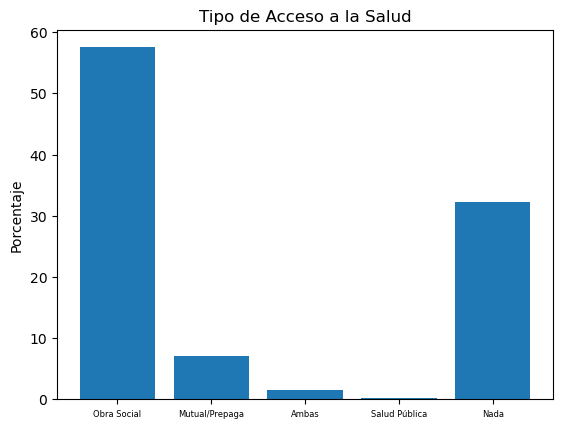

In [30]:
diccionario_valores = {
    'Obra Social': porcentaje_ObraSocial,
    'Mutual/Prepaga': porcentaje_Mutual_Prepaga,
    'Ambas': porcentaje_ObraSocial_y_Mutual,
    'Salud Pública': porcentaje_SaludPublica,
    'Nada': porcentaje_NoPaga
}
etiquetas = list(diccionario_valores.keys())
valores = list(diccionario_valores.values())

# Crear el gráfico de barras
grafico1 = plt.bar(etiquetas, valores)

# Etiquetas y título
plt.ylabel('Porcentaje')
plt.title('Tipo de Acceso a la Salud')

plt.xticks(fontsize=6)

<BarContainer object of 3 artists>

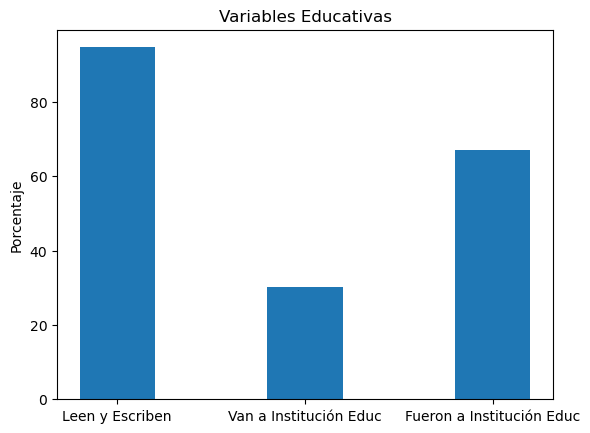

In [31]:
diccionario_valores1 = {'Leen y Escriben': porcentaje_Lee, 'Van a Institución Educ': porcentaje_asiste, 'Fueron a Institución Educ': porcentaje_asistio}
categorias1 = list(diccionario_valores1.keys())
mis_valores1 = list(diccionario_valores1.values())

plt.ylabel('Porcentaje')
plt.title('Variables Educativas')
plt.bar(categorias1, mis_valores1, width=0.4)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Primaria Incompleta'),
  Text(1, 0, 'Primaria Completa'),
  Text(2, 0, 'Secundaria Incompleta'),
  Text(3, 0, 'Secundaria Completa'),
  Text(4, 0, 'Universidad Incompleta'),
  Text(5, 0, 'Universidad Completa'),
  Text(6, 0, 'Sin Instruccion')])

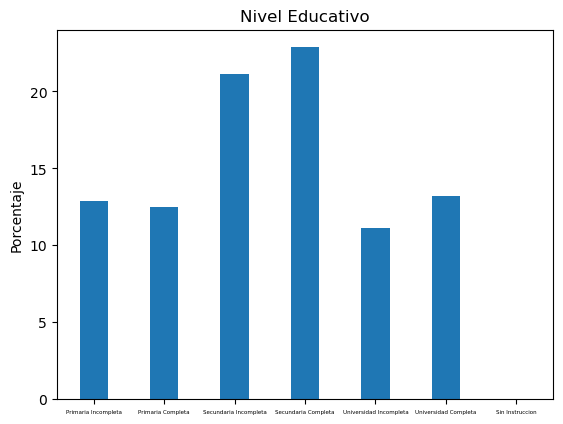

In [32]:
diccionario_valores2 = {'Primaria Incompleta': porcentaje_Primaria_In, 'Primaria Completa': porcentaje_Primaria_Com, 'Secundaria Incompleta': porcentaje_Secundaria_In, 'Secundaria Completa': porcentaje_Secundaria_Com, 'Universidad Incompleta': porcentaje_Universidad_In, 'Universidad Completa': porcentaje_Universidad_Com, 'Sin Instruccion': porcentaje_Sin_Instruccion}
categorias2 = list(diccionario_valores2.keys())
mis_valores2 = list(diccionario_valores2.values())

plt.bar(categorias2, mis_valores2, width=0.4)  # Crear el gráfico de barras

# Personalización opcional del gráfico
plt.ylabel('Porcentaje')  # Etiqueta del eje y
plt.title('Nivel Educativo')

plt.xticks(fontsize=4)


In [23]:
#7) Repetimos el código del inciso 1.2.f del TP2

#Abrimos el archivo "tabla adulto equiv.xlsx"

adulto = pd.read_excel("../datasets/tabla_adulto_equiv.xlsx")

#Acomodamos la base:

adulto=adulto[4:27] #Nos quedamos solo con las celdas que nos interesan
adulto["Edad"]=adulto["Tabla de equivalencias de necesidades energéticas. Unidades de adulto equivalente, según sexo y edad"]
adulto["1"]=adulto["Unnamed: 1"]
adulto["0"]=adulto["Unnamed: 2"]
adulto= adulto[["Edad", "1", "0"]]

adulto["Edad"]=adulto["Edad"].str.replace("años", "").str.replace("año", "").str.replace(" ", "").str.replace("a", "")
adulto = adulto.set_index("Edad")

def equivalencia(edad, genero):
    if edad <18: #No hay observaciones con edades menor a 1, asi que la aquivalencia para las personas de menos de 1 año de edad no es un problema en este caso
        equiv= adulto.at[str(edad),str(genero)]
    if edad>=18 and edad <30:
        equiv= adulto.at["1829", str(genero)]
    if edad>=30 and edad <46:
        equiv= adulto.at["3045", str(genero)]   
    if edad>=46 and edad <61:
        equiv= adulto.at["4660", str(genero)]   
    if edad>=61 and edad <76: #No queda claro en la tabla, pero asumimos que las personas de 75 están incluidas en esta categoría
        equiv= adulto.at["6175", str(genero)]    
    if edad>=76:
        equiv= adulto.at["másde75", str(genero)] 
    return(equiv)  

eph["adulto_equiv"]= eph.apply(lambda x: equivalencia(x.CH06, x.CH04_2), axis=1)

#Generamos una base que suma las equivalencias por hogar, y luego unimos esa base a la nuestra.

suma=eph.groupby(by=["CODUSU", "NRO_HOGAR"]).agg({"adulto_equiv":"sum"})
suma["ad_equiv_hogar"]=suma["adulto_equiv"]
suma = suma.drop('adulto_equiv', axis=1)

# Y hacemos un merge con el df "suma" que contiene la variable de factor de equivalencia por hogar (ad_equiv_hogar)
eph=eph.merge(suma, on=['CODUSU','NRO_HOGAR'], how='left')

In [24]:
#8) Repetimos los incisos 1.3 y 1.4 del TP2

#Guarden como una base distinta llamada respondieron las observaciones donde respondieron la pregunta sobre su ITF. 
#Las observaciones con ITF = 0 guardenlas en una base bajo el nombre norespondieron.

respondieron=eph[eph["ITF"]>0]
norespondieron=eph[eph["ITF"]==0]

respondieron["ingreso_necesario"]= 57371.05*respondieron["ad_equiv_hogar"]

C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\2312687420.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  respondieron=eph[eph_indiv["ITF"]>0]
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\2312687420.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  norespondieron=eph[eph_indiv["ITF"]==0]
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\2312687420.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["ingreso_necesario"]= 57371.05*respondieron["ad_equiv_hogar"]


In [25]:
#9) Agreguen a la base respondieron una columna llamada pobre, que tome valor 1 si el ITF es menor al ingreso necesario que necesita esa familia y 0 en caso contrario

respondieron["pobre"] = (respondieron["ITF"]< respondieron["ingreso_necesario"]).astype(int)


C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\604457598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["pobre"] = (respondieron["ITF"]< respondieron["ingreso_necesario"]).astype(int)


In [26]:
#10) Nos quedamos con una observación por hogar para calcular la tasa de pobreza:

hogares = respondieron.groupby(['CODUSU', 'NRO_HOGAR']).head(1)
pobreza= ((hogares["pobre"]*hogares["PONDIH"]).sum()/hogares["PONDIH"].sum())*100
print("Tasa de pobreza para el GBA:", pobreza)

Tasa de pobreza para el GBA: 32.878420127960986


## Parte II: Construcción de funciones

Solo para asegurarnos que las funciones están funcionando correctamente, las probaremos en unos vectores creados aleatoriamente:

In [36]:
# Creamos los objetos X e y
np.random.seed(42)
y = np.round(np.random.rand(1000)) #dummy
X = np.random.rand(1000, 5)
X = pd.DataFrame(X)


# Dividimos la base en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

1) Creamos la función `evalua_metodo()`, la cual nos permitirá crear métricas necesarias para evaluar distintos modelos de predicción.

In [37]:
def evalua_metodo(model, X_train, y_train, X_test, y_test, showmc=False, showroc=False):
    '''
    El objetivo de esta función es analizar un modelo de clasificación binaria y generar métricas para evaluar su desempeño.
    Argumentos:
    - modelo definido
    - Muestras de entrenamiento (X_train y y_train)
    - Muestras de testeo (X_test y y_test)
    
    La función devuelve como outputs las siguientes métricas:
    - matriz de confusión
    - accuracy
    - área bajo la curva ROC (AUC)
    - ECM
    '''
    
    modelfit = model.fit(X_train, y_train) #previamente definimos el modelo (logit, KNN, LDA)
    y_pred = modelfit.predict(X_test)

    # Métricas para evaluación:
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    matriz_confusion = confusion_matrix(y_test, y_pred)
    ecm = mean_squared_error(y_test, y_pred)

    # Visualización de matriz de confusión:
    if showmc==True:
        mc_plot = sns.heatmap(matriz_confusion, annot=True, fmt='g', cmap='Blues', xticklabels=['Falso', 'Verdadero'], yticklabels=['Falso', 'Verdadero'], annot_kws={"fontsize": 12})
        mc_plot.set_xlabel('Predicción')
        mc_plot.set_ylabel('Observado')
        plt.show()

    # Visualización de curva ROC:
    if showroc==True:
        fpr_mod, tpr_mod, thresholds_mod = roc_curve(y_test, y_pred)
        display = RocCurveDisplay(fpr=fpr_mod, tpr=tpr_mod, roc_auc=auc)
        display.plot()
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.show() 
    
    # Visualización de métricas:
    model_metrics = pd.DataFrame({'model': [model], 'accuracy': [accuracy], 'auc':[auc], 'ecm':[ecm]})
    return model_metrics

Probamos que el comando `evalua_metodo()` funcione correctamente:

In [38]:
evalua_metodo(LogisticRegression(), X_train, y_train, X_test, y_test) #puede ser cualquier modelo: KNN o LDA.

,model,accuracy,auc,ecm
0,LogisticRegression(),0.485,0.510283,0.515


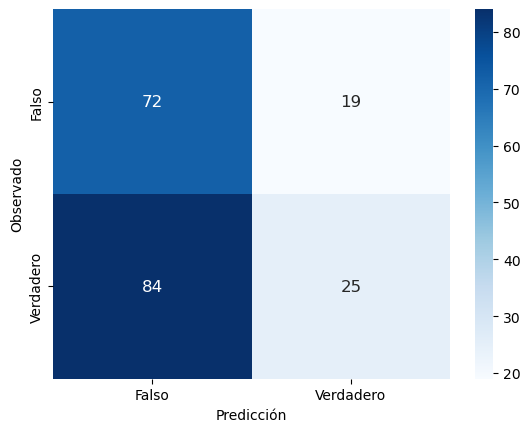

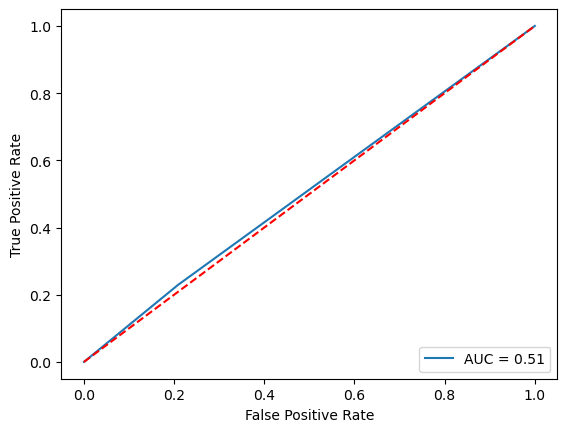

,model,accuracy,auc,ecm
0,LogisticRegression(),0.485,0.510283,0.515


In [39]:
# Le agregué una opción para visualizar la matriz de confusión, por si sirve.
evalua_metodo(LogisticRegression(), X_train, y_train, X_test, y_test, showmc=True, showroc=True)

2. Creamos la función `cross_validation()` la cual nos permitirá hacer la validación cruzada con *k* iteraciones.

In [40]:
def cross_validation(model, k, X, y):
    '''
    El objetivo de esta función es realizar un k-fold cross validation para evaluar el desempeño de un modelo de clasificación binaria.
    La función parte el dataset en K particiones de entrenamiento y test, y aplica la función evalua_metodo para cada una de las particiones.
    
    Argumentos:
    - modelo: El modelo de clasificación a evaluar.
    - k: parámetro para cross validation.
    - X: conjunto de datos de características.
    - y: La variable objetivo. 
    
    La función retorna un df que contiene el número de iteraciones (k), precisión y ECM promedio.
    
    '''
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model_metrics = evalua_metodo(model, X_train, y_train, X_test, y_test)
        model_metrics['k'] = i
        results.append(model_metrics)
    
    combined_results = pd.concat(results, ignore_index=True)
    
    # Calculamos la ECM promedio
    mean_accuracy = combined_results['accuracy'].mean()
    mean_ecm = combined_results['ecm'].mean()
    mean_auc=combined_results['auc'].mean()
    
    return pd.DataFrame({'model': [model], 'k': [k], 'accuracy_mean': [mean_accuracy], 'ecm_mean': [mean_ecm], 'auc_mean': [mean_auc]})

Probemos que la función `cross_validation()` funcione correctamente.

In [41]:
cross_validation(LogisticRegression(max_iter=10000), 5, X, y)

,model,k,accuracy_mean,ecm_mean,auc_mean
0,LogisticRegression(max_iter=10000),5,0.439,0.561,0.444563


3. Creamos la función `evalua_config()` que recibirá distintas combinaciones de hiperparámetros. Utilizamos la función `cross_validation()` previamente creada para cada configuración. La función devuelve la configuración que genera el menor ECM.

In [42]:
def evalua_config(configs, X_train, y_train, k):
    """
    El objetivo es evaluar distintas configuraciones de hiperparámetros 
    que definen a un modelo y devolver la mejor configuración con menor ECM.
    
    Argumentos:
    - configs (list): las distintas configuraciones a evaluar.
    - Muestras de entrenamiento (X_train y y_train)
    - k: parámetro para cross validation.
    
    El output es un diccionario con la mejor configuración y el menor ECM.
    """
    
    best_config = None
    menor_ecm = np.inf
    
    for config in configs:
        modelo = LogisticRegression(max_iter=1000, **config)
        resultados = cross_validation(modelo, k, X_train, y_train)
        ecm_promedio = resultados["ecm_mean"].mean() # El ECM promedio de las k iteraciones

    # Actualizamos la mejor configuración y el menor ECM:
        if ecm_promedio < menor_ecm:
            menor_ecm=ecm_promedio
            best_config=config 
    
    return {
        'Mejor configuración': best_config,
        'ECM menor': menor_ecm 
    }
    

Probamos que la función `evalua_config` esté funcionando correctamente. Creamos algunas configuraciones para que nos dé cuál es la mejor.

In [43]:
configlist = [
     {'penalty': 'l1', 'C': 0.5, 'solver': 'saga'},
     {'penalty': 'l1', 'C': 1, 'solver': 'saga'},  
     {'penalty': 'l2', 'C': 0.5},
     {'penalty': 'l2', 'C': 1}  
    ]

resultado = evalua_config(configlist, X_train, y_train,10)
print(resultado)

{'Mejor configuración': {'penalty': 'l1', 'C': 0.5, 'solver': 'saga'}, 'ECM menor': 0.5175}


4. Escriban una función llamada `evalua_multiples_métodos` que les permita implementar los siguiente métodos con los hiperparámetros que ustedes elijan.

In [44]:
def evalua_multiples_metodos(configs_log, X_train, y_train, X_test, y_test, k, vecinos, componentes):
      
    """
    El objetivo es implementar distintos metodos con los hiperparametros a eleccion y  
    obtener metricas que permitan evaluarlos.
    
    Argumentos:
    - configs_log (list): las distintas configuraciones a evaluar para la regresion logistica.
    - Muestras de entrenamiento (X_train y y_train)
    - Muestras de testeo (X_test y y_test)
    - k: parámetro para cross validation.
    - vecinos (list): distintos numeros de vecinos a evaluar para el metodo de Vecinos Cercanos
    - componentes: numero de componentes para el Analisis Discriminante Lineal
    
    El output es un data frame que contiene el modelo, el valor de los hiperparametros, el ECM, el accuracy, y el AUC para cada modelo.
    """
    
    
    result= pd.DataFrame(columns=["modelo", "penalty", "C", "vecinos", "componentes", "ecm", "accuracy", "auc"])
    
    #Regresion logistica:
    mejor_conf= evalua_config(configs_log, X_train, y_train, k)
    mejor_conf= mejor_conf["Mejor configuración"]
    best_logistic_model=LogisticRegression(max_iter=10000, **mejor_conf) 
    metrics= evalua_metodo(best_logistic_model, X_train, y_train, X_test, y_test)
    result = result.append({"modelo": "Logit", "penalty": mejor_conf["penalty"], "C": mejor_conf["C"], "ecm": metrics.loc[metrics.index[0], "ecm"], "accuracy": metrics.loc[metrics.index[0], "accuracy"], "auc": metrics.loc[metrics.index[0], "auc"]}, ignore_index=True) 
    
    #KNN:
    for v in vecinos:
        knn = KNeighborsClassifier(n_neighbors=v)
        metrics=evalua_metodo(knn, X_train, y_train, X_test, y_test)
        result = result.append({"modelo": "KNN", "vecinos": v, "ecm": metrics.loc[metrics.index[0], "ecm"], "accuracy": metrics.loc[metrics.index[0], "accuracy"], "auc": metrics.loc[metrics.index[0], "auc"]}, ignore_index=True) 

   #LDA:
    lda=LinearDiscriminantAnalysis(n_components=componentes)
    metrics=evalua_metodo(lda, X_train, y_train, X_test, y_test)
    result = result.append({"modelo": "LDA", "componentes": componentes, "ecm": metrics.loc[metrics.index[0], "ecm"], "accuracy": metrics.loc[metrics.index[0], "accuracy"], "auc": metrics.loc[metrics.index[0], "auc"]}, ignore_index=True) 

    return result    

In [45]:
#Probamos que evalua_multiples_metodos funcione:

configlist = [
    {'penalty': 'l1', 'C': 0.5, 'solver': 'saga'},
    {'penalty': 'l1', 'C': 1, 'solver': 'saga'},
    {'penalty': 'l2', 'C': 0.5},
    {'penalty': 'l2', 'C': 1} 
    ]

vecinos_prueba= [1, 5, 10]

evalua_multiples_metodos(configlist, X_train, y_train, X_test, y_test, 5, vecinos_prueba, 1)


C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\46788431.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({"modelo": "Logit", "penalty": mejor_conf["penalty"], "C": mejor_conf["C"], "ecm": metrics.loc[metrics.index[0], "ecm"], "accuracy": metrics.loc[metrics.index[0], "accuracy"], "auc": metrics.loc[metrics.index[0], "auc"]}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\46788431.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({"modelo": "KNN", "vecinos": v, "ecm": metrics.loc[metrics.index[0], "ecm"], "accuracy": metrics.loc[metrics.index[0], "accuracy"], "auc": metrics.loc[metrics.index[0], "auc"]}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\46788431.py:32: FutureWarning: The frame.append method is deprec

,modelo,penalty,C,vecinos,componentes,ecm,accuracy,auc
0,Logit,l1,0.5,NaN,NaN,0.540,0.460,0.503680
1,KNN,NaN,NaN,1,NaN,0.475,0.525,0.521575
2,KNN,NaN,NaN,5,NaN,0.465,0.535,0.538008
3,KNN,NaN,NaN,10,NaN,0.470,0.530,0.544309
4,LDA,NaN,NaN,NaN,1,0.505,0.495,0.519458


## Parte III: Clasificación y regularización

El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona es o no pobre utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder cuánto ganan. Esta vez lo haremos con la base unida de las preguntas de la encuesta individual y la encuesta de hogar.  su vez, incluiremos ejercicios de regularización y de validación cruzada.

1. Eliminamos de las bases `respondieron` y `norespondieron` las variables relacionadas a ingresos y las variables creadas en base al método de adulto equivalente. Creamos la variable dependiente (pobre) y la matriz de variables independientes. En la parte I, como parte de la limpieza de datos, ya eliminamos casi todas estas variables, salvo ITF

In [46]:
#Eliminamos ITF de ambas bases, y tambien PONDIH, que no es util para la prediccion.
#Tambien eliminamos las variables "adulto_equiv", "ad_equiv_hogar" y "ingreso_necesario"
respondieron=respondieron.drop(columns=["ITF", "PONDIH", "adulto_equiv", "ad_equiv_hogar", "ingreso_necesario"])
norespondieron=norespondieron.drop(columns=["ITF", "adulto_equiv", "ad_equiv_hogar", "PONDIH"])


In [47]:
# Variable dependiente: pobre
y = respondieron["pobre"]
y=y.to_numpy()

In [217]:
#Matriz de variables independientes:
X = respondieron.drop(columns=["pobre", "CODUSU", "NRO_HOGAR"])
X= sm.add_constant(X) 

#Dividimos la muestra en test y control
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


KeyError: "['pobre' 'CODUSU' 'NRO_HOGAR'] not found in axis"

In [49]:
#Estandarizamos las variables:
sc = StandardScaler()

# Estandarizamos las observaciones de entrenamiento
X_train_tran = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

# Estandarizamos las observaciones de test
X_test_tran= pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)

# Estadisticas luego de estandarizar
X_train_tran.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
const,4075.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000
H15_1,4075.0,0.0,1.0,-2.695,0.371,0.371,0.371,0.371
AGLOMERADO_33,4075.0,0.0,1.0,-2.072,0.483,0.483,0.483,0.483
CH03_10,4075.0,0.0,1.0,-0.052,-0.052,-0.052,-0.052,19.221
CH03_2,4075.0,-0.0,1.0,-0.485,-0.485,-0.485,-0.485,2.064
...,...,...,...,...,...,...,...,...
II1,4075.0,0.0,1.0,-2.670,-0.931,-0.062,0.808,4.285
II3_1,4075.0,-0.0,1.0,-0.265,-0.265,-0.265,-0.265,11.043
IX_TOT,4075.0,-0.0,1.0,-1.483,-0.952,0.110,0.641,4.888
IX_MEN10,4075.0,-0.0,1.0,-0.641,-0.641,-0.641,0.404,7.712


2. Corremos la función `evalua_multiples_metodos()` con la base respondieron. Este ejercicio nos permite verificar que la función no tienen ningún problema; sin embargo, los valores que toman los hiperparámetros son arbitrarias. Luego veremos cómo elegir la configuración óptima.

In [302]:
configlist = [
    {'penalty': 'l2', 'C': 0.1},
    {'penalty': 'l2', 'C': 100}, 
    {'penalty': 'l1', 'C': 0.1, 'solver': 'saga'},
    {'penalty': 'l1', 'C': 100, 'solver': 'saga' }
    ]

vecinos_prueba= [3, 5]

evalua_multiples_metodos(configlist, X_train_tran, y_train, X_test_tran, y_test, 5, vecinos_prueba, 1)

C:\Users\aleja\AppData\Local\Temp\ipykernel_6112\46788431.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({"modelo": "Logit", "penalty": mejor_conf["penalty"], "C": mejor_conf["C"], "ecm": metrics.loc[metrics.index[0], "ecm"], "accuracy": metrics.loc[metrics.index[0], "accuracy"], "auc": metrics.loc[metrics.index[0], "auc"]}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_6112\46788431.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({"modelo": "KNN", "vecinos": v, "ecm": metrics.loc[metrics.index[0], "ecm"], "accuracy": metrics.loc[metrics.index[0], "accuracy"], "auc": metrics.loc[metrics.index[0], "auc"]}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_6112\46788431.py:32: FutureWarning: The frame.append method is deprecate

,modelo,penalty,C,vecinos,componentes,ecm,accuracy,auc
0,Logit,l1,0.1,NaN,NaN,0.266928,0.733072,0.679914
1,KNN,NaN,NaN,3,NaN,0.227674,0.772326,0.748510
2,KNN,NaN,NaN,5,NaN,0.245339,0.754661,0.720968
3,LDA,NaN,NaN,NaN,1,0.264966,0.735034,0.688182


**3.** Lambda es el valor de penalización a la "complejidad" del modelo. O sea, es lo nuestro modelo "paga" por añadir una variable adicional al modelo. Una forma de elegir el valor de lambda óptimo es usar cross-validation.

Primero, deberíamos dividir los datos en un conjunto de training y test. Luego, podríamos generar una lista con posibles valores de lambda, por ejemplo, los valores [0.001, 0.01, 0.1, 1, 10, 100].

Segundo, deberíamos decidir cuántos *folds (k)* vamos a usar para la cross-validation. Como mencionamos en el siguiente inciso, la regla práctica es usar un valor de 5 o 10.

Tercero, para cada valor de lambda, haremos la cross-validation. Esto quiere decir que, para cada iteración, dividiremos la muestra de entrenamiento en k *folds*, luego entrenar el modelo con regularización (puede ser Ridge o Lasso) en los *k*-1 *folds*, evaluar el rendimiento en el *fold* restante y obtener una métrica como el ECM o accuracy. 

Finalmente, promediar las métricas de todas las iteraciones para cada valor de lambda.

De esta forma, podremos identificar al valor de lambda que nos produzca la mejor métrica. Por ejemplo, el lambda asociado al menor ECM sería el **lambda óptimo**, el cual eligiríamos como la mejor configuración.

No se debe usar el conjunto de test para elegir el valor de lambda debido a que eso podría llevar a una situación de *overfitting* del modelo al conjunto de test. Esto quiere decir que es como si el modelo se ajustara al conjunto de test. Nuestro objetivo es generar un modelo que nos ayude a predecir cuando tengamos nuevos datos, por lo tanto, el conjunto de test debe ser reservado para este propósito. De esta manera, nuestras estimaciones cuando tengamos nueva data serán más confiables.


**4.** En *cross-validation* es importante la elección de los *folds (k)* para poder entrenar y posteriormente evaluar el rendimiento de un modelo. 

Si se elige un *k* muy pequeño, entonces tendremos una mayor cantidad de datos para la muestra de test, pero una menor cantidad para la muestra de entrenamiento, por lo que es posible tener el problema de que la precisión del modelo sea menor. En este caso, la posibilidad de que la distribución de los datos para test difiera del conjunto de training es mayor. Esto quiere decir que las predicciones serían sensibles a valores particulares, por ejemplo, algunos valores outliers.

Por otro lado, un *k* muy grande implica que cada modelo usa una base de training mayor y la base de test es menor. Hacer esto puede tener un costo computacional enorme si trabajamos con muchas observaciones y muchos predictores. Finalmente, cuando *k* es muy grande, puede existir una alta correlación entre *folds* lo que nos llevaría a pensar que, en el margen, una nueva partición no agrega tanta información al modelo. El caso extremo es el *leave-one-out* donde *k* = N, es decir, se deja una sola observación para test y se estima el modelo N veces con N-1 datos. En este último caso, el costo computacional es extremadamente alto.

[Kohavi (1995)](https://dl.acm.org/doi/10.5555/1643031.1643047) mostró que, para seleccionar un modelo, la validación cruzada de cinco o diez veces (*k*) puede ser mejor que la validación leave-one-out. En ese sentido, para evitar los costos computacionales de usar un *k* demasiado alto, está ampliamente difundido la regla práctica de usar un *k* de 5 o 10.

**5.** Crearemos un vector con distintos valores de $\lambda = 10^{n}$ donde $n$ pertenece al intervalo $\{-5, \dots, 5\}$. Además, usamos diez folds para cross-validation ($k=10$).

In [50]:
configlist_LASSO = []

for n in range (-5, 6):
    conf={}
    conf["penalty"]="l1"
    conf["C"]= 1/(10**n)
    conf["solver"]= "saga"
    configlist_LASSO.append(conf)
    
configlist_RIDGE = []

for n in range (-5, 6):
    conf={}
    conf["penalty"]="l2"
    conf["C"]= 1/(10**n)
    configlist_RIDGE.append(conf)    

In [53]:
evalua_config(configlist_LASSO, X_train_tran, y_train, 10)

{'Mejor configuración': {'penalty': 'l1', 'C': 0.1, 'solver': 'saga'},
 'ECM menor': 0.2711910439851616}

In [54]:
evalua_config(configlist_RIDGE, X_train_tran, y_train, 10)

{'Mejor configuración': {'penalty': 'l2', 'C': 0.01},
 'ECM menor': 0.27143313099195454}

Definimos una función que genera un data frame que muestra para cada condiguración y partición del CV el Error Cuadrático Medio

In [55]:
def tabla_ecm_particiones(configs, X_train_data, y_train_data, k):
    """
    El objetivo es evaluar con cross validation distintas configuraciones de hiperparámetros 
    que definen a un modelo y devolver un data frame que muestre para cada configuración el error cuadratico medio
    para cada una de las particiones.
    
    Argumentos:
    - configs (list): las distintas configuraciones a evaluar.
    - X_train_data: conjunto de entrenamiento de los predictores
    - y_train_data: conjunto de entrenamiento de la variable dependiente
    - k: numero de folds para cross validation.
    
    El output es un data frame donde las columnas son el hiperparámetro lamda, la partición y el error cuadratico medio.
    """
    ecms = pd.DataFrame(columns=["lamda", "particion", "ecm"])
    
    for config in configs:
        model = LogisticRegression(max_iter=1000, **config)
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
        for i, (train_index, test_index) in enumerate(kf.split(X_train_data), 1):
            X_train, X_test = X_train_data.iloc[train_index], X_train_data.iloc[test_index]
            y_train, y_test = y_train_data[train_index], y_train_data[test_index]
            metrics = evalua_metodo(model, X_train, y_train, X_test, y_test)
            ecm= metrics.loc[metrics.index[0], "ecm"]
            ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)  
            
        
    return ecms

In [219]:
#Usamos la función para obtener la tabla para las configuraciones evaluadas previamente:
ecms_RIDGE=tabla_ecm_particiones(configlist_RIDGE, X_train_tran, y_train, 10)
ecms_RIDGE

C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is depre

C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is depre

C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is depre

C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3433475834.py:26: FutureWarning: The frame.append method is depre

,lamda,particion,ecm
0,0.00001,1.0,0.240196
1,0.00001,2.0,0.225490
2,0.00001,3.0,0.272059
3,0.00001,4.0,0.274510
4,0.00001,5.0,0.289216
...,...,...,...
105,100000.00000,6.0,0.412776
106,100000.00000,7.0,0.341523
107,100000.00000,8.0,0.329238
108,100000.00000,9.0,0.353808


Para el caso de LASSO, generamos una función que además de devolver el Error Cuadrático Medio, devuelva también la proporción de coeficientes que toman valor 0 para cada configuración de hiperparámetros y para cada partición del CV.

In [62]:
def tabla_ecm_coeficientes_lasso(configs, X_train_data, y_train_data, k):
    """
    El objetivo es evaluar con cross validation distintas configuraciones de hiperparámetros 
    que definen a un modelo de Regresion Logistica con LASSO y devolver un data frame que muestre 
    para cada una de las particiones de cada configuración el error cuadratico medio y la proporcion 
    de variables para las que el coeficiente es 0.
    
    Argumentos:
    - configs (list): las distintas configuraciones a evaluar.
    - X_train_data: conjunto de entrenamiento de los predictores
    - y_train_data: conjunto de entrenamiento de la variable dependiente
    - k: numero de folds para cross validation.
    
    El output es un data frame donde las columnas son el hiperparámetro lamda, la partición, el error cuadratico medio
    y la proporcion de variables para las que el coeficiente es 0.
    """
    ecms = pd.DataFrame(columns=["lamda", "particion", "ecm", "proporcion_0"])
    
    for config in configs:
        model = LogisticRegression(max_iter=1000, **config)
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
        for i, (train_index, test_index) in enumerate(kf.split(X_train_data), 1):
            X_train, X_test = X_train_data.iloc[train_index], X_train_data.iloc[test_index]
            y_train, y_test = y_train_data[train_index], y_train_data[test_index]
            metrics = evalua_metodo(model, X_train, y_train, X_test, y_test)
            ecm= metrics.loc[metrics.index[0], "ecm"]
            
            
            modelfit=model.fit(X_train, y_train)
            coeficientes_finales = pd.DataFrame([np.array(X_train.columns.tolist()), modelfit.coef_[0]]).T
            coeficientes_finales.columns = ['feature','coeficiente']

            coef_0 = (coeficientes_finales['coeficiente'] == 0).sum()
            proporcion_0= coef_0 / len(coeficientes_finales)
            ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)  
            
        
    return ecms

In [63]:
ecms_LASSO=tabla_ecm_coeficientes_lasso(configlist_LASSO, X_train_tran, y_train, 10)
ecms_LASSO

C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coe

C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed 

C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coe

C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed 

C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coe

C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)
C:\Users\aleja\AppData\Lo

C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\3807042613.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ecms = ecms.append({"lamda": 1/config["C"], "particion": i, "ecm": ecm, "proporcion_0": proporcion_0}, ignore_index=True)
C:\Users\aleja\AppData\Lo

,lamda,particion,ecm,proporcion_0
0,0.00001,1.0,0.240196,0.004464
1,0.00001,2.0,0.232843,0.004464
2,0.00001,3.0,0.272059,0.004464
3,0.00001,4.0,0.272059,0.004464
4,0.00001,5.0,0.286765,0.004464
...,...,...,...,...
105,100000.00000,6.0,0.412776,1.000000
106,100000.00000,7.0,0.341523,1.000000
107,100000.00000,8.0,0.329238,1.000000
108,100000.00000,9.0,0.353808,1.000000


[Text(0, 0, '1e-0.5'),
 Text(1, 0, '0.0001'),
 Text(2, 0, '0.001'),
 Text(3, 0, '0.01'),
 Text(4, 0, '0.1'),
 Text(5, 0, '1'),
 Text(6, 0, '10'),
 Text(7, 0, '100'),
 Text(8, 0, '1000'),
 Text(9, 0, '10000'),
 Text(10, 0, '1e+0.5')]

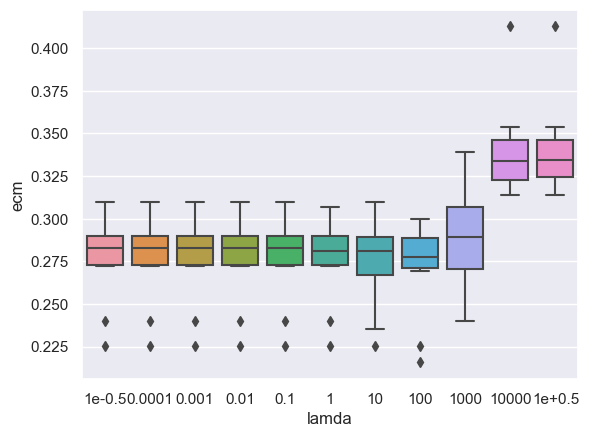

In [221]:
import seaborn as sns
sns.set()

#Graficamos el Boxplot para Ridge:
box_RIDGE = sns.boxplot(data=ecms_RIDGE, x="lamda", y="ecm")
box_RIDGE.set_xticklabels(['1e-0.5', '0.0001', '0.001', "0.01", "0.1", "1", "10", "100", "1000", "10000", "1e+0.5"])


[Text(0, 0, '1e-0.5'),
 Text(1, 0, '0.0001'),
 Text(2, 0, '0.001'),
 Text(3, 0, '0.01'),
 Text(4, 0, '0.1'),
 Text(5, 0, '1'),
 Text(6, 0, '10'),
 Text(7, 0, '100'),
 Text(8, 0, '1000'),
 Text(9, 0, '10000'),
 Text(10, 0, '1e+0.5')]

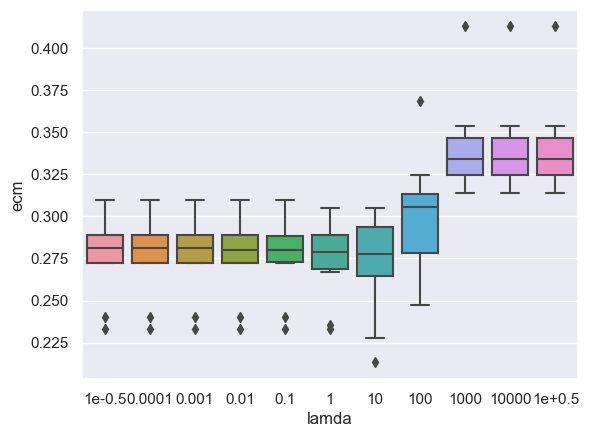

In [214]:
#Graficamos el Boxplot para Lasso que muestra la distribución en el Error Cuadrático Medio para las que el coeficiente es 0 según el lamda

box_LASSO = sns.boxplot(data=ecms_LASSO, x="lamda", y="ecm")
box_LASSO.set_xticklabels(['1e-0.5', '0.0001', '0.001', "0.01", "0.1", "1", "10", "100", "1000", "10000", "1e+0.5"])

[Text(0, 0, '1e-0.5'),
 Text(1, 0, '0.0001'),
 Text(2, 0, '0.001'),
 Text(3, 0, '0.01'),
 Text(4, 0, '0.1'),
 Text(5, 0, '1'),
 Text(6, 0, '10'),
 Text(7, 0, '100'),
 Text(8, 0, '1000'),
 Text(9, 0, '10000'),
 Text(10, 0, '1e+0.5')]

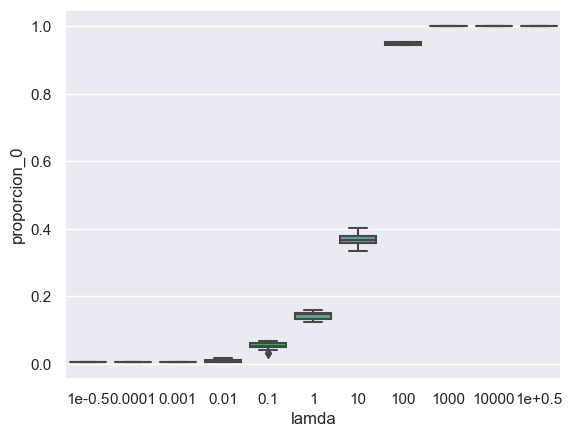

In [222]:
#Graficamos el Boxplot para Lasso que muestra la distribución en la proporción de variables para las que el coeficiente es 0 según el lamda

box_LASSO_coeficientes = sns.boxplot(data=ecms_LASSO, x="lamda", y="proporcion_0")
box_LASSO_coeficientes.set_xticklabels(['1e-0.5', '0.0001', '0.001', "0.01", "0.1", "1", "10", "100", "1000", "10000", "1e+0.5"])

Ejercicio 6

In [72]:
#Para el modelo con el valor óptimo de Lamda (10), generamos un dataframe que contenga los coeficientes asignados a cada variable, y dos dataframes que contienen los coeficientes que toman valor igual a 0 y distinto de 0.
model = LogisticRegression(max_iter=1000, penalty="l1", C=0.1, solver="saga")
model.fit(X_train_tran, y_train)
coeficientes = pd.DataFrame([np.array(X_train_tran.columns.tolist()), model.coef_[0]]).T
coeficientes.columns = ['feature','coeficiente']
ceros=coeficientes.drop(coeficientes[coeficientes["coeficiente"]!=0].index)
noceros=coeficientes.drop(coeficientes[coeficientes["coeficiente"]==0].index)
coeficientes


,feature,coeficiente
0,const,0.0
1,H15_1,-0.006047
2,AGLOMERADO_33,-0.037921
3,CH03_10,0.0
4,CH03_2,0.0
...,...,...
219,II1,-0.005857
220,II3_1,0.011625
221,IX_TOT,0.303958
222,IX_MEN10,0.0


**6.** A continuación, mostramos las variables que tienen un coeficiente de cero; es decir, las variables que fueron descartadas. A continuación, comentaremos algunas de las variables más llamativas y justificaremos la decisión de descartarlas:

* `ESTADO_3 `: Esta variable es una dummy que indica que la persona es inactiva. La categoría base es estar ocupado. Podría tener sentido que una situación de inactividad no ayude a explicar si la persona es pobre o no, principalmente, porque esta población incluye a los jubilados o estudiantes. Aparentemente, tiene mayor relevancia estar desocupado (no inactivo) para predecir la pobreza.
* `CAT_OCUP`s : Estas variables son dummies por cada tipo de ocupación. Nuestro modelo nos muestra que la condición de estar ocupado es necesaria para predecir la pobreza; sin embargo, el tipo de ocupación para no ser tan relevante para la predicción.
* `CAT_INAC`s: Previamente mencionamos que la condición de inactividad quedó descartada como predictor. Entonces, los distintos tipos de inactividad también fueron descartados.
* `PP02C1` - `PP02C8`: Son variables relacionadas a la forma de búsqueda de trabajo, como si es que tiene contactos, si consultó parientes, se anotó en bolsas de trabajo, contestó avisos en diarios/internet, etc. Estas variables fueron descartadas por el modelo. Es posible que el mecanismo por el cual las personas encuentran trabajo no es relevante para predecir la condición de pobreza. Lo que importa es tener o no trabajo, por lo que la variable `ESTADO_2` sí fue considerada por modelo, ya que muestra la diferencia entre los ocupados y desocupados.
* `IV1_6` - `II9_2`: Son variables relacionadas a las características del hogar. Por ejemplo, tenemos el tipo de vivienda, usos que se le da a las habitaciones, material del techo, si tiene activos como cocina, lavadero, garage, etc. Esto nos pareció extraño, ya que esperaríamos que estas variables del hogar sean también relevantes para predecir la pobreza. Bajo el enfoque multidimensional de la pobreza, estas variables pertenecen también a una dimensión relevante. Sin embargo, algunas otras variables sobre características del hogar sí fueron aceptadas por el modelo. Por ejemplo, el número de habitaciones, si el agua se obtiene por cañería o fuera del terreno, o si es agua de red pública o perforación con bomba a motor. Esto nos da una idea de que no todas las características del hogar ayudan para predecir correctamente la pobreza, sino solamente aquellas que influyen -quizá- de manera más directa en la calidad de vida de las personas.
* `VII1_1` - `VII2_4`: Las variables sobre cómo se organizan las tareas en el hogar no ayuda para predecir la pobreza.
* `IX_MEN`: La cantidad de miembros en el hogar menores a 10 años también fue descartada.

Si bien se descartan muchas variables que inicialmente creíamos relevantes para medir el bienestar de las personas, es importante recordar que en la EPH se mide la **pobreza monetaria**. Según el enfoque de pobreza multidimensional, pueden existir otras dimensiones relevantes para el desarrollo humano, como la educación o las condiciones del hogar, que no son abarcadas bajo el enfoque unidimensional monetario. Esto quiere decir, pueden existir *pobre invisibles* que no captura el enfoque monetario. Por tanto, como en esta investigación buscamos predecir la pobreza monetaria, algunas variables pueden ser descartadas; sin embargo, las mismas podrían ser relevantes para un enfoque multidimensional de la pobreza.

In [207]:
cero_values = ceros['feature'].tolist()
cero_values

['const',
 'CH03_10',
 'CH03_2',
 'CH07_2.0',
 'CH07_5.0',
 'CH10_1.0',
 'CH10_2.0',
 'CH10_3.0',
 'CH13_1.0',
 'CH13_2.0',
 'CH15_4.0',
 'CH16_4.0',
 'ESTADO_3.0',
 'CAT_OCUP_1.0',
 'CAT_OCUP_3.0',
 'CAT_INAC_5',
 'CAT_INAC_6',
 'CAT_INAC_7',
 'PP02C1_1',
 'PP02C1_2',
 'PP02C2_1',
 'PP02C3_1',
 'PP02C3_2',
 'PP02C4_1',
 'PP02C4_2',
 'PP02C5_1',
 'PP02C5_2',
 'PP02C6_2',
 'PP02C7_1',
 'PP02C7_2',
 'PP02C8_1',
 'PP02C8_2',
 'PP02E_1',
 'PP02H_2',
 'PP02I_2',
 'IV1_6',
 'IV4_3.0',
 'IV6_3',
 'IV7_4',
 'IV9_1',
 'IV9_2',
 'IV10_2',
 'IV10_3',
 'IV11_1',
 'IV11_4',
 'II2_2',
 'II2_4',
 'II3_1',
 'II3_2',
 'II4_1_1',
 'II4_2_1',
 'II4_2_2',
 'II4_3_2',
 'II5_1',
 'II5_2',
 'II6_1',
 'II6_2',
 'II7_1.0',
 'II7_2.0',
 'II8_1',
 'II9_2',
 'V2_2.0',
 'V22_2',
 'V3_2.0',
 'V4_2.0',
 'V14_2.0',
 'VII1_1_5.0',
 'VII1_2_3',
 'VII1_2_8',
 'VII2_1_6',
 'VII2_1_97',
 'VII2_2_5',
 'VII2_2_9',
 'VII2_3_1',
 'VII2_3_6',
 'VII2_4_5',
 'VII2_4_6',
 'CH12',
 'IX_MEN10']

**7.**

En el ejercicio 5 podemos ver que el desempeño de LASSO y RIDGE es similar. El Error Cuadrático Medio para el lamda óptimo en regresión logística con RIDGE es 0.2714 y con LASSO es 0.2711, por lo que son similares, si bien el ECM de LASSO es ligeramente menor. No obstante, el lamda óptimo varía entre ambos métodos de regularización (es 10 para LASSO y 100 para Ridge). Esto también puede observarse en los Box plots, que muestran que en el caso de Ridge el lamda=100 es el que genera el ECM promedio más bajo y con menos varianza, mientras que para el caso de LASSO los lamdas a partir de 100 comienzan a tener Errores Cuadrático Medio Mayores. Esto se debe, en parte, a que a partir de esa penalidad la proporción de coeficientes que toman valor 0 se acerca mucho a 1 y se vuelve igual a 1 para todo lamda a partir de 1000. 

**8.**

Obtenemos las métricas de precisión para los dos modelos logit con lamda optimos, para el modelo de vecinos cercanos (con 3 y 5 vecinos), y para el modelo de Análisis Discriminante Lineal.

Observamos que el método que predice mejor es el de Vecinos Cercanos con 3 vecinos, ya que tiene menor Error Cuadrático Medio, mayor área bajo la curva ROC y mayor Accuracy.


In [57]:

configlist = [{'penalty': 'l1', 'C': 0.1, 'solver': 'saga'}, {'penalty': 'l2', 'C': 0.01}]

vecinos_prueba= [3, 5]

evalua_multiples_metodos(configlist, X_train_tran, y_train, X_test_tran, y_test, 5, vecinos_prueba, 1)

C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\46788431.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({"modelo": "Logit", "penalty": mejor_conf["penalty"], "C": mejor_conf["C"], "ecm": metrics.loc[metrics.index[0], "ecm"], "accuracy": metrics.loc[metrics.index[0], "accuracy"], "auc": metrics.loc[metrics.index[0], "auc"]}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\46788431.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({"modelo": "KNN", "vecinos": v, "ecm": metrics.loc[metrics.index[0], "ecm"], "accuracy": metrics.loc[metrics.index[0], "accuracy"], "auc": metrics.loc[metrics.index[0], "auc"]}, ignore_index=True)
C:\Users\aleja\AppData\Local\Temp\ipykernel_17332\46788431.py:32: FutureWarning: The frame.append method is deprec

,modelo,penalty,C,vecinos,componentes,ecm,accuracy,auc
0,Logit,l1,0.1,NaN,NaN,0.266928,0.733072,0.679914
1,KNN,NaN,NaN,3,NaN,0.227674,0.772326,0.748510
2,KNN,NaN,NaN,5,NaN,0.245339,0.754661,0.720968
3,LDA,NaN,NaN,NaN,1,0.264966,0.735034,0.688182


**9.**

Utilizamos el método de vecinos cercanos con 3 vecinos para predecir la pobreza en la base norespondieron. 

In [202]:
X_nr = norespondieron.drop(columns=["CODUSU", "NRO_HOGAR"])
X_nr["const"]= 1 
variables_X=X_train.columns.tolist()
X_nr=X_nr[variables_X] #Hacemos que las variables en X_nr tengan el mismo orden que en la base que usamos para entrenar el modelo.

#Notamos que la variable "II3_1" aparece duplicada, así que nos quedamos con 1 sola:
column_values = X_nr.iloc[:, 115].values
X_nr["prueba"]=column_values
column_values_train = X_train.iloc[:, 115].values
X_train["prueba"]=column_values_train
X_nr=X_nr.drop(columns=["II3_1"])
X_train=X_train.drop(columns=["II3_1"])
X_nr = X_nr.rename(columns={'prueba': 'II3_1'})
X_train = X_train.rename(columns={'prueba': 'II3_1'})

#Usamos el modelo de vecinos cercanos con 3 vecinos para predecir la pobreza en la base norespondieron
knn = KNeighborsClassifier(n_neighbors=3)
knnfit= knn.fit(X_train, y_train)
y_pred_knn = knnfit.predict(X_nr)




In [203]:
norespondieron['prediccion_pobreza'] = y_pred_knn

In [204]:
#Nos quedamos con una observación por hogar para calcular la tasa de pobreza:

hogares = norespondieron.groupby(['CODUSU', 'NRO_HOGAR']).head(1)
pobres_count=(hogares['prediccion_pobreza'] == 1).sum()
nopobres_count=(hogares['prediccion_pobreza'] == 0).sum()
total=nopobres_count + pobres_count

print("El porcentaje de hogares pobres predicho en la muestra norespondieron es:", pobres_count*100/total)

El porcentaje de hogares pobres predicho en la muestra norespondieron es: 72.37113402061856


El porcentaje de pobreza predicho es alto (72,37%). Podría ocurrir que las personas que no reportan su ingreso, o que reportan que es 0 sea porque este es bajo, en cuyo caso sería esperable que la tasa de pobreza en esta submuestra sea mayor que para el subconjunto de hogares que sí reportaron ingresos.